In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import time
import numpy as np
import string
!pip install octis
import matplotlib.pyplot as plt
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.preprocessing.preprocessing import Preprocessing
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.similarity_metrics import RBO
from octis.evaluation_metrics.classification_metrics import F1Score
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

In [3]:
# here is octis source file:
# /usr/local/lib/python3.7/dist-packages/octis/

In [4]:
os.chdir(os.path.pardir)

# Initialize preprocessing
preprocessor = Preprocessing(vocabulary=None, max_features=None,
                             remove_punctuation=True, punctuation=string.punctuation,
                             lemmatize=True, stopword_list='english')
# preprocess
dataset = preprocessor.preprocess_dataset(documents_path='/content/drive/MyDrive/NLP_final_project/output_type_2_w_shuffle.csv')
# dataset = preprocessor.preprocess_dataset(documents_path='/content/output_type_2_w_shuffle.csv')

# save the preprocessed dataset
dataset.save('/content/drive/MyDrive/NLP_final_project/dataset')

created vocab
3079


In [5]:
print("number of error messages:", len(dataset._Dataset__corpus))
print("vocabulary size:", len(dataset._Dataset__vocabulary))

number of error messages: 7821
vocabulary size: 3079


**Work with data**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/NLP_final_project/dataset/corpus.tsv', sep="\t", header=None)
df.tail()

In [ ]:
print(df[1] == "test")

In [ ]:
total_dataset = df.shape[0]

In [ ]:
train = df[df[1] == "train"].shape[0]
test = df[df[1] == "test"].shape[0]

In [ ]:
print("train: ", train/total_dataset)
print("test: ", test/total_dataset)
print("valid: ", 1 - ((train+test)/total_dataset))

# TODO: change the code of OCTIS to get the train and test set as you want - 80, 10, 10

**First model - LDA**

In [6]:
# initialize the model for hyperparameter tuning
from octis.models.LDA import LDA
model_lda = LDA(num_topics=10)

In [ ]:
trained_model = model_lda.train_model(dataset)

Optimize the model

In [ ]:
# select the evaluation metric of optimization
cv = Coherence(texts=dataset.get_corpus(), measure='c_v')

In [ ]:
optimization_runs=50
model_runs=5

In [ ]:
# search space for doing the experiments for optimization
search_space = {
                "num_topics": Integer(2, 50),
                "alpha": Real(0.01, 2),
                "eta": Real(0.01, 2)
}

In [ ]:
import time
start = time.time()
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model_lda, dataset, cv, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='/content/results/test_lda/')
end = time.time()
print('Optimizing model took: ' + str(round(end - start)) + ' seconds.')

In [ ]:
# save the results of the optimization
optimization_result.save_to_csv("/content/drive/MyDrive/NLP_final_project/optimize_lda_main.csv")

Run the model with the best optimization metric

In [10]:
model_lda_best = LDA(num_topics=34, alpha=0.31, eta=1.6)

In [64]:
# run everything for multiple times
cv_array, div_array, rbo_array = [], [], []
for i in range(10):
    output_lda = model_lda_best.train_model(dataset)
    cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
    diversity = TopicDiversity(topk=10) 
    rbo = RBO(topk=10)

    cv_array.append(cv.score(output_lda)) 
    div_array.append(diversity.score(output_lda))
    rbo_array.append(rbo.score(output_lda))

In [47]:
cv = np.array(cv_array)
div = np.array(div_array)
rbo = np.array(rbo_array)

print(cv.mean(), cv.std())
print(div.mean(), div.std())
print(rbo.mean(), rbo.std())

0.4070959700629769 0.017289014919732774
0.585 0.018899204501667474
0.053088893524229706 0.010771979477750878


In [11]:
output_lda = model_lda_best.train_model(dataset)

In [ ]:
cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
npmi = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_npmi')
print("Coherence - cv: " + str(cv.score(output_lda)))
print("Coherence - npmi: " + str(npmi.score(output_lda)))

In [ ]:
diversity = TopicDiversity(topk=10) 
print("Diversity: " + str(diversity.score(output_lda)))

In [ ]:
rbo = RBO(topk=10)
print("RBO Score: " + str(rbo.score(output_lda)))

Coherence: 0.4070959700629769 - 0.017289014919732774

Diversity: 0.585 - 0.018899204501667474

Similiarity: 0.053088893524229706 - 0.010771979477750878


Work with the result

In [ ]:
print(*list(output_lda.keys()), sep="\n")

In [ ]:
# most repeated words in each topic
# QUESTION: how to write "topic NUMBER" before each sentence?
for topic in output_lda['topics']:
    print(" ".join(topic))

In [ ]:
# all the probabilities of test set on each topic
out = output_lda["test-topic-document-matrix"].transpose()
print(out.shape)
numpy.savetxt("/content/lda_probabilities.csv", out, delimiter=",")

In [ ]:
print(out)

In [ ]:
# Question: How to get the test sentences from this dataset? (I think they are not in the dataset - where are they?) - to append to the results of probabilities
for att in dir(dataset):
    print (att, getattr(dataset,att))

In [ ]:
trained_model["topics"][192]

In [ ]:
numpy.argmax(trained_model['test-topic-document-matrix'].T[401])

In [ ]:
dicc = {}
for i in range(len(trained_model['test-topic-document-matrix'])):
    count = []
    for indx in range(len(trained_model['test-topic-document-matrix'].T)):
        if numpy.argmax(trained_model['test-topic-document-matrix'].T[indx]) == i:
            count.append(indx)
    if count != 0:
        dicc[i] = count
dicc

**Second model - CTM (ZeroShotTm)**

In [50]:
# initialize the model for hyperparameter tuning
from octis.models.CTM import CTM

In [ ]:
model_ctm = CTM(num_topics=7)

Optimize the model

In [ ]:
cv = Coherence(texts=dataset.get_corpus(), measure='c_v')

In [ ]:
search_space = {"num_topics": Integer(2, 50),
                "num_layers": Integer(1,5), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)}

In [ ]:
optimization_runs=50
model_runs=5

In [ ]:
start = time.time()
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model_ctm, dataset, cv, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='/content/results/test_ctm/')
end = time.time()
# duration = end - start
print('Optimizing model took: ' + str(round(end - start)) + ' seconds.')

In [ ]:
optimization_result.save_to_csv("/content/drive/MyDrive/NLP_final_project/optimize_ctm_main.csv")

Run the model with the best optimization metric

In [51]:
model_ctm_best = CTM(num_topics=6, num_layers=1, num_neurons=200, activation='relu', dropout=0.78, bert_model="bert-base-nli-mean-tokens")

In [52]:
# run everything for multiple times
cv_array, div_array, rbo_array = [], [], []
for i in range(10):
    output_ctm = model_ctm_best.train_model(dataset)
    cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
    diversity = TopicDiversity(topk=10) 
    rbo = RBO(topk=10)

    cv_array.append(cv.score(output_ctm)) 
    div_array.append(diversity.score(output_ctm))
    rbo_array.append(rbo.score(output_ctm))

In [53]:
cv = np.array(cv_array)
div = np.array(div_array)
rbo = np.array(rbo_array)

print(cv.mean(), cv.std())
print(div.mean(), div.std())
print(rbo.mean(), rbo.std())

0.53242577972432 0.036130016516643035
0.7433333333333334 0.05066228051190223
0.12112041673733331 0.046580519435826


In [13]:
output_ctm = model_ctm_best.train_model(dataset)

In [ ]:
cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
npmi = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_npmi')
print("Coherence - cv: " + str(cv.score(output_ctm)))
print("Coherence - npmi: " + str(npmi.score(output_ctm)))

In [ ]:
diversity = TopicDiversity(topk=10) 
print("Diversity: " + str(diversity.score(output_ctm)))

In [ ]:
rbo = RBO(topk=10)
print("RBO Score: " + str(rbo.score(output_ctm)))

Coherence: 0.53242577972432 - 0.036130016516643035

Diversity: 0.7433333333333334 - 0.05066228051190223

Similiarity: 0.12112041673733331 - 0.046580519435826

Work with the result

In [ ]:
for topic in output_ctm['topics']:
    print(" ".join(topic))

In [ ]:
import json
res = json.load(open("/content/results/test_ctm/result.json",'r'))
res.keys()

In [ ]:
res['x_iters']['activation']

In [ ]:
res["f_val"]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(res["f_val"])

In [ ]:

plt.plot(res["f_val"])

Third model - NeuralLDA (AVITM)

In [54]:
# initialize the model for hyperparameter tuning
from octis.models.NeuralLDA import NeuralLDA
model_neural_lda = NeuralLDA(num_topics=20)

In [ ]:
cv = Coherence(texts=dataset.get_corpus(), measure='c_v')

Optimize the model

In [ ]:
optimization_runs=50
model_runs=5

In [ ]:
search_space = {"num_topics": Integer(2, 50),
                "num_layers": Integer(1,5), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)}

In [ ]:
optimizer=Optimizer()
import time
start = time.time()
optimization_result = optimizer.optimize(
    model_neural_lda, dataset, cv, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='results/test_neuralLDA/')
end = time.time()
duration = end - start
optimization_result.save_to_csv("results_neuralLDA.csv")
print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

In [ ]:
optimization_result.save_to_csv("/content/drive/MyDrive/NLP_final_project/optimize_neural_lda_main.csv")

Run the model with the best optimization metric



In [55]:
model_neural_lda_best = NeuralLDA(num_topics=40, num_layers=1, num_neurons=200, dropout=0.31)

In [ ]:
# run everything for multiple times
cv_array, div_array, rbo_array = [], [], []
for i in range(10):
    output_neural_lda = model_neural_lda_best.train_model(dataset)
    cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
    diversity = TopicDiversity(topk=10) 
    rbo = RBO(topk=10)

    cv_array.append(cv.score(output_neural_lda)) 
    div_array.append(diversity.score(output_neural_lda))
    rbo_array.append(rbo.score(output_neural_lda))

In [57]:
cv = np.array(cv_array)
div = np.array(div_array)
rbo = np.array(rbo_array)

print(cv.mean(), cv.std())
print(div.mean(), div.std())
print(rbo.mean(), rbo.std())

0.49216635496634575 0.011462169025774039
0.5165 0.04928488612140644
0.10039612402271703 0.02029037478683014


In [ ]:
output_neural_lda = model_neural_lda_best.train_model(dataset)

In [ ]:
cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
npmi = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_npmi')
print("Coherence - cv: " + str(cv.score(output_neural_lda)))
print("Coherence - npmi: " + str(npmi.score(output_neural_lda)))

In [ ]:
diversity = TopicDiversity(topk=10) 
print("Diversity: " + str(diversity.score(output_neural_lda)))

In [ ]:
rbo = RBO(topk=10)
print("RBO Score: " + str(rbo.score(output_neural_lda)))

Coherence: 0.49216635496634575 - 0.011462169025774039

Diversity: 0.5165 - 0.04928488612140644

Similiarity: 0.10039612402271703 - 0.02029037478683014


Fourth model - ETM

In [58]:
# initialize the model for hyperparameter tuning
from octis.models.ETM import ETM

In [ ]:
model_etm = ETM(num_topics=7, num_epochs=100)

Optimize the model

In [ ]:
cv = Coherence(texts=dataset.get_corpus(), measure='c_v')

In [ ]:
search_space = {"num_topics": Integer(2, 50),
                "num_layers": Integer(1,5), 
                "num_neurons": Categorical({100, 200, 300}),
                "dropout": Real(0.0, 0.95)}

In [ ]:
optimization_runs=50
model_runs=5

In [ ]:
start = time.time()
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model_etm, dataset, cv, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='/content/results/test_etm/')
end = time.time()
# duration = end - start
print('Optimizing model took: ' + str(round(end - start)) + ' seconds.')

In [ ]:
optimization_result.save_to_csv("/content/drive/MyDrive/NLP_final_project/optimize_etm_main.csv")

Run the model with the best optimization metric


In [59]:
model_etm_best = ETM(num_topics=9, t_hidden_size=800, dropout=0.22)

In [ ]:
# run everything for multiple times
cv_array, div_array, rbo_array = [], [], []
for i in range(10):
    output_etm = model_etm_best.train_model(dataset)
    cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
    diversity = TopicDiversity(topk=10) 
    rbo = RBO(topk=10)

    cv_array.append(cv.score(output_etm)) 
    div_array.append(diversity.score(output_etm))
    rbo_array.append(rbo.score(output_etm))

In [61]:
cv = np.array(cv_array)
div = np.array(div_array)
rbo = np.array(rbo_array)

print(cv.mean(), cv.std())
print(div.mean(), div.std())
print(rbo.mean(), rbo.std())

0.48171506796524827 0.03765191651048745
0.7033333333333334 0.08165721789632502
0.1058934925384127 0.05816478179339525


In [ ]:
output_etm = model_etm_best.train_model(dataset)

In [ ]:
cv = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_v')
npmi = Coherence(texts=dataset.get_corpus(),topk=10, measure='c_npmi')
print("Coherence - cv: " + str(cv.score(output_etm)))
print("Coherence - npmi: " + str(npmi.score(output_etm)))

In [ ]:
diversity = TopicDiversity(topk=10) 
print("Diversity: " + str(diversity.score(output_etm)))

In [ ]:
rbo = RBO(topk=10)
print("RBO Score: " + str(rbo.score(output_etm)))

Coherence: 0.48171506796524827 - 0.03765191651048745

Diversity: 0.7033333333333334 - 0.08165721789632502

Similiarity: 0.1058934925384127 - 0.05816478179339525

Create multiple visualizations

In [21]:
import pandas as pd
optimize_neural_lda_result = pd.read_csv('/content/drive/MyDrive/NLP_final_project/optimize_neural_lda_main.csv')
optimize_ctm_result = pd.read_csv('/content/drive/MyDrive/NLP_final_project/optimize_ctm_main.csv')
optimize_lda_result = pd.read_csv('/content/drive/MyDrive/NLP_final_project/optimize_lda_main.csv')
optimize_etm_result = pd.read_csv('/content/drive/MyDrive/NLP_final_project/optimize_etm_main.csv')

In [ ]:
optimize_lda_result['Mean(model_runs)']

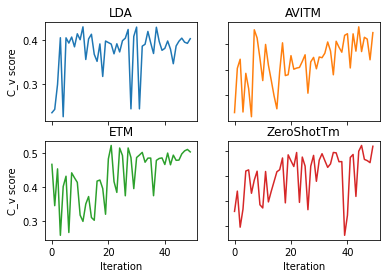

In [47]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(optimize_lda_result['Mean(model_runs)'])
axs[0, 0].set_title('LDA')
axs[0, 1].plot(optimize_neural_lda_result['Mean(model_runs)'], 'tab:orange')
axs[0, 1].set_title('AVITM')
axs[1, 0].plot(optimize_etm_result['Mean(model_runs)'], 'tab:green')
axs[1, 0].set_title('ETM')
axs[1, 1].plot(optimize_ctm_result['Mean(model_runs)'], 'tab:red')
axs[1, 1].set_title('ZeroShotTm')

for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='C_v score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

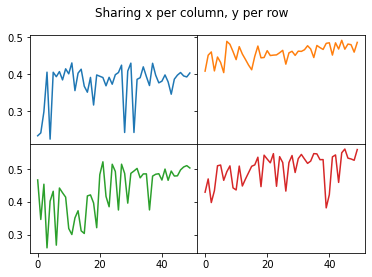

In [29]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})
(ax1, ax2), (ax3, ax4) = axs
fig.suptitle('Sharing x per column, y per row')
ax1.plot(optimize_lda_result['Mean(model_runs)'])
ax2.plot(optimize_neural_lda_result['Mean(model_runs)'], 'tab:orange')
ax3.plot(optimize_etm_result['Mean(model_runs)'], 'tab:green')
ax4.plot(optimize_ctm_result['Mean(model_runs)'], 'tab:red')

for ax in axs.flat:
    ax.label_outer()